In [4]:
import os
from pydantic import BaseModel
from typing import List
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph,START,END
from langchain_community.document_loaders import TextLoader


In [5]:
docs=TextLoader("research_notes.txt",encoding="utf-8").load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
chunk=splitter.split_documents(docs)

In [6]:
embeddings=HuggingFaceEmbeddings()
vectorstore=FAISS.from_documents(chunk,embedding=embeddings)
retriever=vectorstore.as_retriever()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 233.15it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [7]:
import os
from langchain_groq.chat_models import ChatGroq
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
from dotenv import load_dotenv
load_dotenv()
llm=ChatGroq(model='openai/gpt-oss-120b')

In [9]:
#State-schem 
class RAGSTATE(BaseModel):
    question:str
    sub_question:List[str]=[]
    retrieved_docs:List[Document]=[]
    answer:str=""


In [13]:
#Query planner:split input question 
def plan_query(state:RAGSTATE)->RAGSTATE:
    prompt=f"""
    Break the follwing complex question into 2-3 sub-questions
    Question :{state.question}
    Sub-question:"""
    result=llm.invoke(prompt)
    state.sub_questions=result
    return state
def retrieve_for_each(state:RAGSTATE)->RAGSTATE:
    all_docs=[]
    for sub in state.sub_questions:
        docs=retriever.invoke(sub)
        all_docs.extend(docs)
    return RAGSTATE(question=state.question,documents=all_docs)

def generate_final_answer(state:RAGSTATE)->RAGSTATE:
    context="\n\n".join([doc.page_content for doc in state.retrieve_docs])
    prompt=f"""
    Use the context to genearate the asnwer to the questioon that will be  asked

    Context:{context}

    Question:{state.question}

    """
    answer=llm.invoke(prompt ).content
    return RAGSTATE(question=state.question,answer=answer)

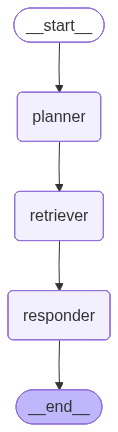

In [14]:
builder=StateGraph(RAGSTATE)
builder.add_node("planner",plan_query)
builder.add_node("retriever",retrieve_for_each)
builder.add_node("responder",generate_final_answer)

builder.set_entry_point("planner")
builder.add_edge("planner","retriever")
builder.add_edge("retriever","responder")
builder.add_edge("responder",END)

graph=builder.compile()
graph 